## 3. Основное квантовое уравнение. Утечка фотонов из полости

<b>Задача:</b>
<em>Решить задачу Коши для квантового основного уравнения модели
Джейнса-Каммингса c RWA приближением с одним атомом в полости и
произвольным начальным состоянием с одним фактором декогерентности $A_1=a$
(утечка фотонов из полости) с интенсивностью $\gamma = \hbar\omega/2$.</em>

Выпишем гамильтониан Джейнса-Каммингса для оптической полости в приближении RWA:

$H = \hbar\omega a^\dagger a + \hbar\omega \sigma^\dagger \sigma + g a \sigma^\dagger + g a^\dagger \sigma$

Если мы учитываем фактор декогерентности $A_1=a$ - утечку фотонов из полости - очевидно, что свойство приближения RWA, заключавшееся в сохранении общей энергии, больше не работает. Однако матрица $H$ все равно остается конечной, так как оператор $a$ лишь уничтожает фотоны, не порождая возбужденные атомы, и таким образом не связывает состояния с начальной общей энергией $E=\hbar \omega n$ с более высокоэнергетическими.

Для простоты будем рассматривать оптическую полость с одним атомом и фотоном и общей энергией в начальный момент времени $E = \hbar \omega$. Как обычно выбираем систему единиц энергии, в которой $\hbar \omega = 1$. Тогда параметр $\gamma = 0.5$. Сначала посмотрим на динамику матрицы плотности без утечки.

Сюда я помещу удобные функции-утилиты из решения предыдущих задач.

In [1]:
from math import *
import numpy as np
import numpy.linalg as linalg

def eigensolver(H):
    e, v = linalg.eig(H)
    idx = e.argsort()[::1]   
    e = e[idx]
    v = v[:,idx]
    return e, v

In [2]:
# coupling with field
g = 0.01

# solution of the Schrodinger equation at t=0
H = np.zeros((2,2))
H[0,0] = 1
H[1,1] = 1
H[0,1] = g
H[1,0] = g
E, v = eigensolver(H)

Теперь попробуем численно решать уравнение Шредингера для матрицы плотности численно:

$i \frac{\partial \rho}{\partial t} = [H,\rho] = H\rho - \rho H$

И в начальный момент времени матрица плотности будет иметь лишь один ненулевой элемент $\rho_{01,01} = 1$.

Метод Эйлера приводит к очень быстрому нарастанию ошибки, поэтому будем использовать метод Рунге-Кутты четвертого порядка.

In [3]:
def runge_kutta_4(t,dim,fun,rho_0,gamma):

    npoints = len(t)
    rho_list = np.zeros((npoints, dim, dim), dtype=np.cdouble)
    rho = np.array(rho_0,dtype=np.cdouble)
    rho_list[0,:,:] = rho
    
    for i in range(1,npoints):

        h = t[i] - t[i-1]

        # Runge-Kutta
        k1 = fun(rho,gamma)
        k2 = fun(rho + 0.5*h*k1,gamma)
        k3 = fun(rho + 0.5*h*k2,gamma)
        k4 = fun(rho + h*k3,gamma)
        rho = rho + 1.0/6.0 * h * (k1 + 2*k2 + 2*k3 + k4)

        rho_list[i,:,:] = rho
    
    return rho_list
    
t = np.linspace(0,1000,1001)

def fun_no_leaks(rho,gamma):
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H))

rho_list = runge_kutta_4(t, 2, fun_no_leaks, [[1,0],[0,0]], 0.0)

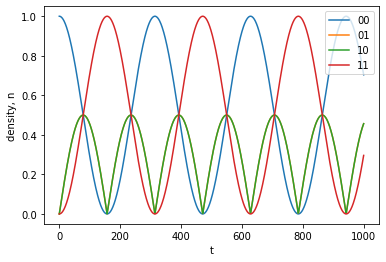

In [4]:
import matplotlib.pyplot as plt

plt.plot(t, abs(rho_list[:,0,0]), label='00')
plt.plot(t, abs(rho_list[:,0,1]), label='01')
plt.plot(t, abs(rho_list[:,1,0]), label='10')
plt.plot(t, abs(rho_list[:,1,1]), label='11')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Теперь можно переходить к решению квантового основного уравнения. Конечно, теперь необходимо завести состояние $|0,0>$, в которое система попадает после потери фотона. Оператор $A_1 = a$ будет связывать это состояние с $|0,1>$ и $|1,0>$ посредством матрицы:

$A_1 = \left( \begin{array}{ccc} 0 & 0 & 1 \\  0 & 0 & 0 \\ 0 & 0 & 0 \end{array} \right)$

(предполагается базис $|0,0>$, $|0,1>$, $|1,0>$).

Супероператор Линдблада выглядит так:

$\mathcal{L}(\rho) = \gamma (A\rho A^\dagger - \frac{1}{2}(A^\dagger A \rho + \rho A^\dagger A))$

Теперь нетрудно подставить этот супероператор в правую часть дифференциальных матричных уравнений и решить их методом Рунге-Кутты. Не забудем сначала построить матрицу $H$ в выбранном базисе.

[0.   0.99 1.01]
[[ 1.          0.          0.        ]
 [ 0.          0.70710678  0.70710678]
 [ 0.         -0.70710678  0.70710678]]


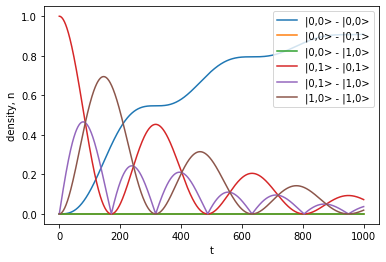

In [5]:
gamma = 0.005

# solution of the Schrodinger equation at t=0
H = np.zeros((3,3))
H[1,1] = 1
H[2,2] = 1
H[1,2] = g
H[2,1] = g
E, v = eigensolver(H)
print(E)
print(v)

A1 = np.array([[0,0,1],[0,0,0],[0,0,0]])
A1conj = np.transpose(A1)

t = np.linspace(0,1000,1001)

def fun_leak(rho,gamma):
    A1conjA1 = np.matmul(A1conj, A1)
    L = gamma * (np.matmul(A1, np.matmul(rho, A1conj)) - 0.5 * (np.matmul(A1conjA1, rho) + np.matmul(rho, A1conjA1)))
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H)) + L

rho_list = runge_kutta_4(t, 3, fun_leak, [[0,0,0],[0,1,0],[0,0,0]], gamma)

basis_labels = ['|0,0>', '|0,1>', '|1,0>']

for i in range(0,3):
    for j in range(i,3):
        plt.plot(t, abs(rho_list[:,i,j]), label=basis_labels[i]+' - ' + basis_labels[j])

plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Напоследок интересно посмотреть эволюцию состояний с $E = 2\hbar\omega$. Эта модель будет описывать последовательную потерю обоих фотонов. Базисные функции запишем в таком порядке:

$|0,0>$, $|1,0>$, $|0,1>$, $|2,0>$, $|1,1>$

Матрица оператора уничтожения фотона в этом базисе:

$A_1 = \left( \begin{array}{ccc} 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 \end{array} \right)$

Матрица гамильтониана в приближении RWA:

$H = \left( \begin{array}{ccc} 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & g & 0 & 0 \\ 0 & g & 1 & 0 & 0 \\ 0 & 0 & 0 & 2 & \sqrt{2}g \\ 0 & 0 & 0 & \sqrt{2}g & 2 \end{array} \right)$

In [6]:
# solution of the Schrodinger equation at t=0
H = np.zeros((5,5))
H[1,1] = 1
H[2,2] = 1
H[3,3] = 2
H[4,4] = 2
H[1,2] = g
H[2,1] = g
H[3,4] = g*sqrt(2)
H[4,3] = g*sqrt(2)
E, v = eigensolver(H)

A1 = np.array([[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0]])
A1conj = np.transpose(A1)

t = np.linspace(0,1000,1001)

rho_0 = np.zeros((5,5))
rho_0[3,3] = 1

rho_list = runge_kutta_4(t, 5, fun_leak, rho_0, gamma)

Динамика диагональных элементов $\rho$:

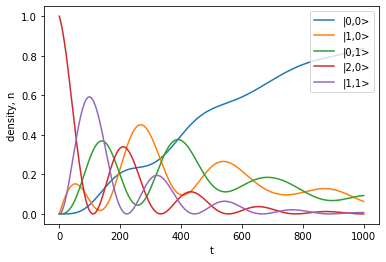

In [7]:
basis_labels = ['|0,0>', '|1,0>', '|0,1>', '|2,0>', '|1,1>']

for i in range(0,5):
    plt.plot(t, abs(rho_list[:,i,i]), label=basis_labels[i])

plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Динамика недиагональных элементов:

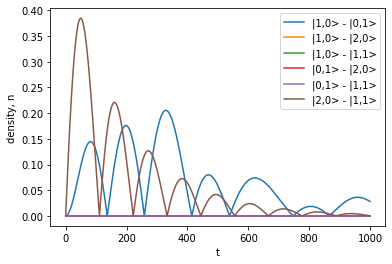

In [8]:
for i in range(1,5):
    for j in range(i+1,5):
        label_ij = basis_labels[i] + ' - ' + basis_labels[j]
        plt.plot(t, abs(rho_list[:,i,j]), label=label_ij)

plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('density, n')
plt.show()

Отметим равенство нулю всех недиагональных матричных элементов, включающих состояние $|0,0>$ -- вылетающий фотон не находится в состоянии запутанности с атомом (и остающимся фотоном, если он есть).

### Квантовое бутылочное горлышко

Пусть за время $\tau$ заселенность стока превысит какое-то пороговое значение (скажем, 90%). Посмотрим, как зависит $\tau$ от параметра $\gamma$, для системы с общей энергией в начальный момент времени $E = \hbar \omega$. Посчитаем $\tau$ для ряда значений $\gamma$.

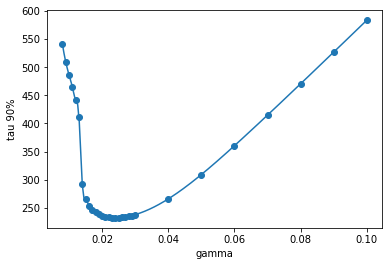

In [87]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, minimize

thresh = 0.9

# Hamiltonian matrix
H = np.zeros((3,3))
H[1,1] = 1
H[2,2] = 1
H[1,2] = g
H[2,1] = g

# initial state: Psi(0) = |0,1>
initial_rho = [[0,0,0],[0,1,0],[0,0,0]]

# leakage matrices
A1 = np.array([[0,0,1],[0,0,0],[0,0,0]])
A1conj = np.transpose(A1)

def find_tau(gamma,tmax,npoints,tguess):
    
    t = np.linspace(0,tmax,npoints)
    rho_list = runge_kutta_4(t, 3, fun_leak, initial_rho, gamma)
    
    occ_00 = interp1d(t, abs(rho_list[:,0,0]), kind='cubic')
    def f(t):
        return occ_00(t)-thresh
    
    plt.plot(t, abs(rho_list[:,0,0]), label='00')
    plt.plot(t, abs(rho_list[:,1,1]), label='01')
    plt.plot(t, abs(rho_list[:,2,2]), label='10')
    plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.ylabel('density, n')
    plt.show()

    tau = fsolve(f, tguess)
    
    return tau

# example:
# tau = find_tau(0.05,1000,1000,500)

gamma_array = [0.008, 0.009, 0.010, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.020, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.030, 0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.100]
tau_array = [540.7594136, 509.3090163, 486.0849791, 464.7174877, 441.8060781, 411.7473868, 292.0745307, 265.7054811, 254.2550909, 247.0636204, 242.1017514, 238.5652340, 236.0429975, 234.2937543, 233.1629127, 232.5452748, 232.3660526, 232.5702842, 233.1165087, 233.9727709, 235.1139790, 236.5200865, 238.1747997, 266.1160168, 309.3360443, 360.5062138, 414.8264053, 470.4120687, 526.6146620, 583.1715535]

tau_spline = interp1d(gamma_array, tau_array, kind='cubic')
x = np.linspace(0.008, 0.1, 200)

plt.scatter(gamma_array, tau_array)
plt.plot(x, tau_spline(x))
plt.xlabel('gamma')
plt.ylabel('tau 90%')
plt.show()

Интересно отметить, что ситуация совсем другая, если в начальный момент времени заселено только состояние $|1,0>$. В этом случае минимум не наблюдается, время $\tau$ монотонно убывает до нуля. Минимуму приблизительно отвечает точка $\gamma_{min} \approx 0.024$. Посмотрим, как выглядят графики заселенностей для точки минимума, а также справа и слева от нее.

gamma = 0.01


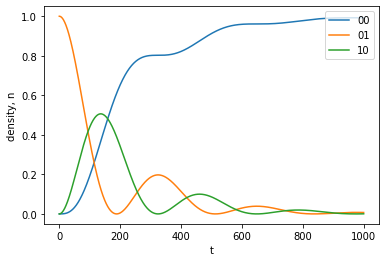

gamma = 0.024


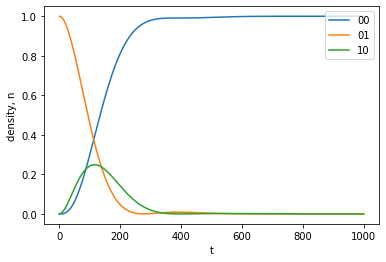

gamma = 0.04


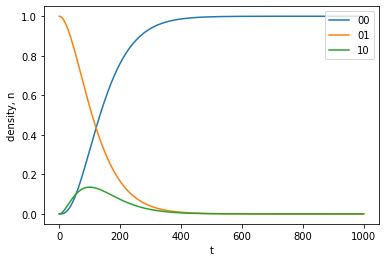

In [96]:
print('gamma = 0.01')
tau = find_tau(0.01,1000,1000,600)

print('gamma = 0.024')
tau = find_tau(0.024,1000,1000,300)

print('gamma = 0.04')
tau = find_tau(0.04,1000,1000,300)
